In [ ]:
# @title Install dependencies
# NOTE: some may be missing or unnecessary because the code below has been changing quickly
!sudo apt-get install -y ffmpeg --quiet
!pip install librosa --quiet
!pip install torchaudio --quiet

In [70]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import argparse
import os
import tqdm
import scipy.ndimage as nd
import os
import torchvision
import torchaudio
import IPython

In [2]:
# Helper functions --> thanks NMA
import random

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

set_seed(2021)
print(torch.cuda.is_available())
DEVICE = set_device()

Random seed 2021 has been set.
True
GPU is enabled in this notebook.


In [3]:
# Input and Hyperparameters

# --input_image   images/supermarket.jpg
datapath = './data'
datapath = os.path.abspath(datapath)
input_image_path = 'misc/notadog.png'
input_image_path = os.path.join(datapath, input_image_path)

# --iterations    number of gradient ascent steps per octave
iterations = 20
iterations = 30

# --at_layer      the layer whose activation we will maximize
dream_layer = 27
#dream_layer = 36 # vgg19 has 36 layers

# --lr            learning rate
lr = 1e-02

# --octave_scale  image scale between octaves
# the image is scaled to progressively smaller fields of view
octave_scale = 1.4

# --num_octaves   number of octaves to zoom in to the image, if your image is not big don't make this too large
num_octaves = 10
num_octaves = 5

/home/jon/Drive/LEVERHULME/COURSES/NEUROMATCH2021/HallucinatingGANs/Code/data/misc/notadog.png
<class 'numpy.ndarray'> float32 (512, 512, 3)


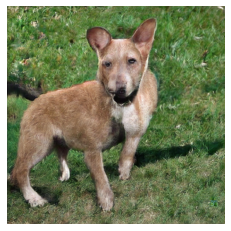

In [4]:
# TODO: look into strategies for converting float images to uint8
# such that we don't have normalization biases...
#from skimage import img_as_ubyte
#img = img_as_ubyte(data)
# see: https://stackoverflow.com/questions/46689428/convert-np-array-of-type-float64-to-type-uint8-scaling-values/46689933

import matplotlib.image as im

print(input_image_path)
input_image = im.imread(input_image_path)

# summarize shape of the pixel array
print(type(input_image), input_image.dtype, input_image.shape)

plt.axis('off')
plt.imshow(input_image)
plt.show()

In [6]:
# Let's try using a spectrogram...
gztan = torchaudio.datasets.GTZAN(os.path.abspath(datapath), download=False)

torch.Size([661794])


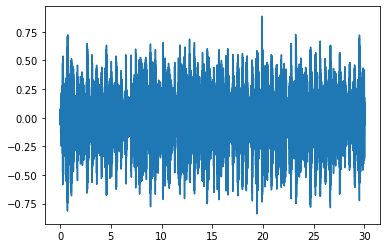

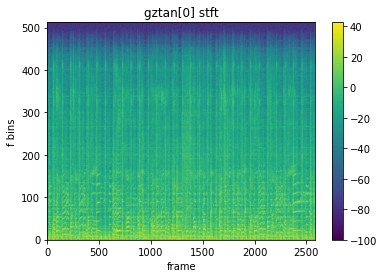

In [7]:
waveform, samplerate, label = gztan[0]
num_chan, num_frames = waveform.shape
waveform = waveform.squeeze() # remove the channel dimension
print(waveform.shape)

plt.figure()
plt.plot(torch.arange(0, num_frames) / samplerate, waveform)
plt.show()

n_fft = 1024
n_mels = 128
win_length = None
hop_length = 256 # smaller hop size leads to better reconstruction but takes longer to compute
power = 2.0 # squared power magnitude spectrogram

get_stft = torchaudio.transforms.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=power,
)
amp_to_db = torchaudio.transforms.AmplitudeToDB('power')

stft = get_stft(waveform)
stft_db = amp_to_db(stft)

fig, axs = plt.subplots(1, 1)
axs.set_title('gztan[0] stft')
axs.set_ylabel('f bins')
axs.set_xlabel('frame')
im = axs.imshow(stft_db, origin='lower', aspect='auto')
fig.colorbar(im, ax=axs)
plt.show(block=False)

In [51]:
print(stft_db.max(), stft_db.min())

stftnorm = normalize(stft_db.reshape(3, 513, -1).unsqueeze(dim=0))

print(stftnorm.max(), stftnorm.min())


tensor(42.4989) tensor(-100.)
tensor(183.4667) tensor(-446.2489)


In [23]:
print(DEVICE)

cuda


In [52]:
# Do a forward pass through the model for testing...
print(stft_db.shape, stft_db.dtype, type(stft_db))

#img_input = torch.tensor(stft_db.reshape(3, 513, -1).unsqueeze(dim=0), device=DEVICE)
img_input = torch.tensor(stftnorm, device=DEVICE)

print("Input: ", type(img_input), img_input.shape, img_input.dtype, img_input.device)

layer = network.features[0]
print(layer)
for p in layer.parameters():
    print(p.device, p.shape, p.dtype)
res = layer(img_input)
print("Output: ", res.shape)

# Get an input image suitable for the code below...
input_image = stft_db.reshape(513, -1, 3).numpy()
print(input_image.shape, type(input_image))

torch.Size([513, 2586]) torch.float32 <class 'torch.Tensor'>
Input:  <class 'torch.Tensor'> torch.Size([1, 3, 513, 862]) torch.float32 cuda:0
Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
cuda:0 torch.Size([64, 3, 3, 3]) torch.float32
cuda:0 torch.Size([64]) torch.float32
Output:  torch.Size([1, 64, 513, 862])
(513, 862, 3) <class 'numpy.ndarray'>


/tmp/ipykernel_16796/661661004.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_input = torch.tensor(stftnorm, device=DEVICE)


In [9]:
# Download the pre-trained model
# VGG is a pretty big model to download, it's a deep architecture but implemented in a way that's easy to chop up...
network = torchvision.models.vgg19(pretrained=True) # vgg19 is very big


# GoogleNet has a pretty complex implementation, see -> https://pytorch.org/vision/stable/_modules/torchvision/models/googlenet.html#googlenet
#network = models.googlenet(pretrained=True)
print("Layers: ")

# Convert the nn layers to a basic python list
layers = list(network.features.children())

# Make a new Sequential function for the layers of the network 
#            up to and including the layer we want to maximize
partial_network = nn.Sequential(*layers[:(dream_layer + 1)])
partial_network.to(DEVICE)

print(network.features)

Layers: 
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18

In [ ]:

#for name, p in network.named_parameters():
#    print(name)

#network.__dict__
#vars(network)
print(network.modules())
for mod in network.modules():
    print(mod)

In [15]:
# Do a forward pass through the model for testing...
image_converted = torch.cuda.FloatTensor(input_image)
print(image_converted.shape, image_converted.dtype, type(image_converted))

img_input = image_converted.permute(2,0,1).unsqueeze(0)
print(img_input.shape)

#result = network.(img_proc)
layer = network.features[0]
print(layer)
res = layer(img_input)
print("Output: ", res.shape)

torch.Size([512, 512, 3]) torch.float32 <class 'torch.Tensor'>
torch.Size([1, 3, 512, 512])
Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Output:  torch.Size([1, 64, 512, 512])


In [40]:
# More helper functions

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

normalize = torchvision.transforms.Normalize(mean, std)
preprocess = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), normalize])


def deprocess(image_np):
    print("Deproccess, incoming image: ", type(image_np), image_np.shape)
    image_np = image_np.transpose(1, 2, 0)
    image_np = image_np * std.reshape((1, 1, 3)) + mean.reshape((1, 1, 3))
    image_np = np.clip(image_np, 0.0, 255.0)
    return image_np

def clip(image_tensor):
    for c in range(3):
        m, s = mean[c], std[c]
        image_tensor[0, c] = torch.clamp(image_tensor[0, c], -m / s, (1 - m) / s)
    return image_tensor

In [41]:
# Extract image representations for each octave
# NOTE: We expect here that input_image is a numpy array with dimensions HEIGHT x WIDTH x CHANNELS(3)

octaves = [input_image[:,:,:3]]
print(octaves[-1].shape)
for i in range(num_octaves - 1):
    zoom_factor = (1 / octave_scale, 1 / octave_scale, 1) # one per axis (H, W, CHANNEL)
    #print(i, octaves[-1])
    print(i, type(octaves[-1]), octaves[-1].shape, zoom_factor)     
    img = nd.zoom(octaves[-1], zoom_factor, order=1)
    octaves.append(img)

(513, 862, 3)
0 <class 'numpy.ndarray'> (513, 862, 3) (0.7142857142857143, 0.7142857142857143, 1)
1 <class 'numpy.ndarray'> (366, 616, 3) (0.7142857142857143, 0.7142857142857143, 1)
2 <class 'numpy.ndarray'> (261, 440, 3) (0.7142857142857143, 0.7142857142857143, 1)
3 <class 'numpy.ndarray'> (186, 314, 3) (0.7142857142857143, 0.7142857142857143, 1)


In [59]:
def dream(image, model, iterations, lr):
    """ Updates the image to maximize outputs for n iterations """
    
    # Convert the numpy array image into a requires_grad=True Tensor that we will optimize
    print("Dream: ", type(image), image.shape)
    #image = np.moveaxis(image, 2, 0)
    #image = torch.tensor(image, requires_grad=True, device=DEVICE)
    image = preprocess(image)
    image = torch.tensor(image, requires_grad=True, dtype=torch.float, device=DEVICE)
    print(".....: ", type(image), image.shape, image.requires_grad, image.grad)
    
    
    # Optimization loop
    for i in range(iterations):
        model.zero_grad()
        out = model(image.unsqueeze(0))
        loss = out.norm()
        loss.backward()
        
        # Update image using gradients...
        #print(i, image.grad)
        # print("data: ", image.data)
        #avg_grad = np.abs(image.grad.data.cpu().numpy()).mean()
        with torch.no_grad():
            absgrad = torch.abs(image.grad)
            norm_lr = lr / absgrad.mean()
            image += norm_lr * image.grad
            image = clip(image)
        
        image.grad.zero_()

    return deprocess(image.detach().cpu().numpy())



detail = np.zeros_like(octaves[-1])

for octave, octave_base in enumerate(tqdm.tqdm(octaves[::-1], desc="Dreaming")):
    if octave > 0:
        # Upsample detail to new octave dimension
        zoom_factor = np.array(octave_base.shape) / np.array(detail.shape)
        detail = nd.zoom(detail, zoom_factor, order=1)
    # Add deep dream detail from previous octave to new base
    img = octave_base + detail
    
    # Get new deep dream image
    dreamed_image = dream(img, partial_network, iterations, lr)
    
    # Extract deep dream details
    detail = dreamed_image - octave_base

#dreamed_image = deprocess(dreamed_image)
print("Output: ", dreamed_image.shape, type(dreamed_image))

Dreaming:   0%|                                                         | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_16796/2110112050.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, requires_grad=True, dtype=torch.float, device=DEVICE)


Dream:  <class 'numpy.ndarray'> (133, 224, 3)
.....:  <class 'torch.Tensor'> torch.Size([3, 133, 224]) True None


Dreaming:  20%|█████████▊                                       | 1/5 [00:01<00:06,  1.57s/it]

Deproccess, incoming image:  <class 'numpy.ndarray'> (3, 133, 224)
Dream:  <class 'numpy.ndarray'> (186, 314, 3)
.....:  <class 'torch.Tensor'> torch.Size([3, 186, 314]) True None


Dreaming:  40%|███████████████████▌                             | 2/5 [00:04<00:06,  2.20s/it]

Deproccess, incoming image:  <class 'numpy.ndarray'> (3, 186, 314)
Dream:  <class 'numpy.ndarray'> (261, 440, 3)
.....:  <class 'torch.Tensor'> torch.Size([3, 261, 440]) True None


Dreaming:  60%|█████████████████████████████▍                   | 3/5 [00:08<00:06,  3.11s/it]

Deproccess, incoming image:  <class 'numpy.ndarray'> (3, 261, 440)
Dream:  <class 'numpy.ndarray'> (366, 616, 3)
.....:  <class 'torch.Tensor'> torch.Size([3, 366, 616]) True None


Dreaming:  80%|███████████████████████████████████████▏         | 4/5 [00:17<00:05,  5.42s/it]

Deproccess, incoming image:  <class 'numpy.ndarray'> (3, 366, 616)
Dream:  <class 'numpy.ndarray'> (513, 862, 3)
.....:  <class 'torch.Tensor'> torch.Size([3, 513, 862]) True None


Dreaming: 100%|█████████████████████████████████████████████████| 5/5 [00:35<00:00,  7.04s/it]

Deproccess, incoming image:  <class 'numpy.ndarray'> (3, 513, 862)
Output:  (513, 862, 3) <class 'numpy.ndarray'>


In [61]:
print(dreamed_image.shape, type(dreamed_image), dreamed_image.max(), dreamed_image.min())

if dreamed_image.min() < 0:
    dreamed_image += np.abs(dreamed_image.min())
if dreamed_image.max() > 1.0:
    dreamed_image = dreamed_image / dreamed_image.max()

print(dreamed_image.max(), dreamed_image.min())


(513, 862, 3) <class 'numpy.ndarray'> 49.05792968750001 0.0
1.0 0.0


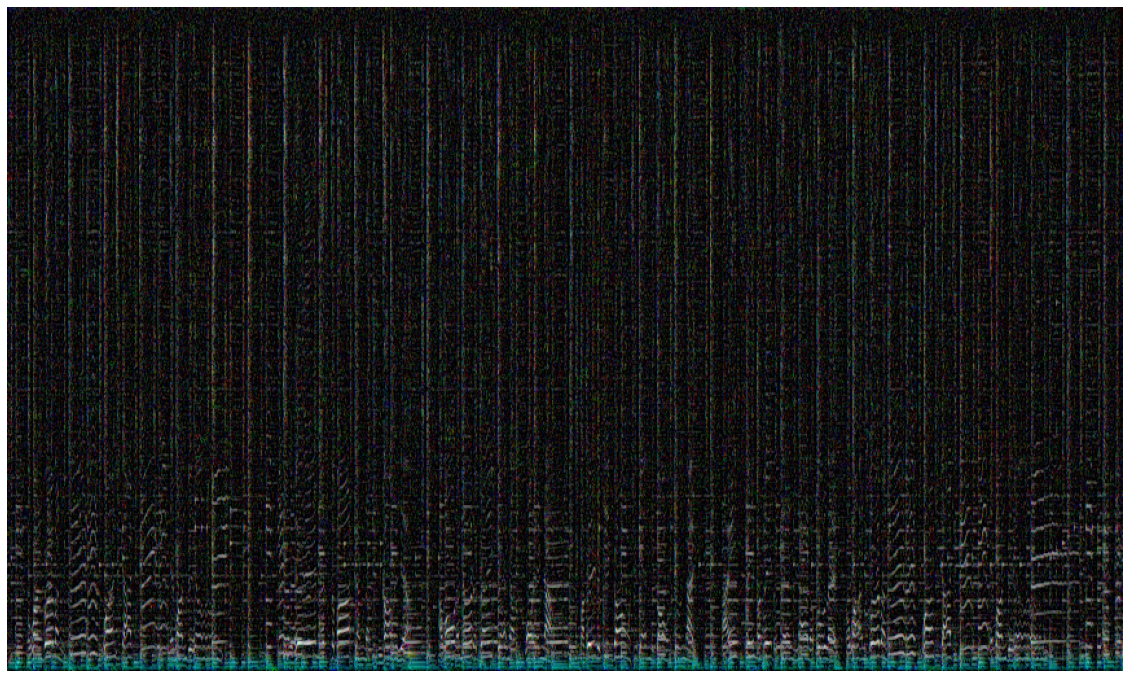

In [65]:
# Save and plot image
outputdir = os.path.join(datapath, 'ddoutputs')
os.makedirs(outputdir, exist_ok=True)
filename = input_image_path.split("/")[-1]
plt.figure(figsize=(20, 20))
plt.imshow(dreamed_image)
plt.axis('off')
plt.imsave(f"{outputdir}/output_{filename}", dreamed_image)
plt.show()

In [71]:
# Reconstruct Audio from spectrogram

def play_audio(waveform, samplerate):
  if type(waveform) == torch.Tensor:
      waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(IPython.display.Audio(data=waveform, rate=samplerate))
  elif num_channels == 2:
    display(IPython.display.Audio(data=(waveform[0], waveform[1]), rate=samplerate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

dreamed_spec = np.flip(dreamed_image, axis=0)
dreamed_spec = np.reshape(dreamed_spec, (513, -1))
dreamed_spec = torch.tensor(dreamed_spec, device='cpu')
print(dreamed_spec.shape)

resynth_griffin_lim = torchaudio.transforms.GriffinLim(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
)

resynthesized_waveform = resynth_griffin_lim(dreamed_spec)

play_audio(resynthesized_waveform.unsqueeze(dim=0), samplerate)

torch.Size([513, 2586])
